In [1]:
# invoke some initial libraries that we want as part of this setup
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
import pyemma.coordinates as coor

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False)
    frames = []
    Ca = u.select_atoms('name CA')    
    for ts in u.trajectory[::]:
        frames.append(Ca.positions.T);
    return np.array(frames);

In [3]:
trajfile = '/Users/7ap/Documents/anca/codes/bpti_ca_1ms_dt10ns_aligned.xtc'
topfile = '/Users/7ap/Documents/anca/codes/bpti_ca.pdb'

In [4]:
coords = getCoordinates(topfile, trajfile)

/anaconda3/lib/python3.6/site-packages/MDAnalysis/lib/mdamath.py:152: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))


In [5]:
plt.style.use('ggplot')

In [6]:
print (coords.shape)

(412497, 3, 58)


In [7]:
import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 5);

In [8]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print (caDevsMDall.shape);

(174, 412497)


In [9]:
Nc = coords.shape[0]; # number of conformers in the simulation
dim = coords.shape[1]; # number of dimensions - usually 3
Na = coords.shape[2]; # number of atoms in the selection (from line 3)

Overall kurtosis for system: 15.936542928556362
Overall Z-score for system: 3778.4359858515854
Overall p-value for system: 0.000000e+00
(52,)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


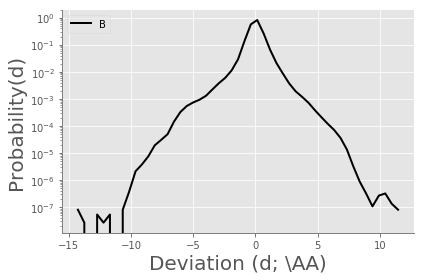

In [10]:
import scipy.stats; 

import os;
os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/texlive/2014/bin/x86_64-darwin/';

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']});
rc('text', usetex=False);

D = caDevsMDall.flatten(); 
[n,s] = np.histogram(D, bins=51,normed=1);
gm = np.mean(D); 
gs = np.std(D);
gK = scipy.stats.kurtosis(D,0,fisher=False);
print('Overall kurtosis for system: ' + str(gK));

gZscore, gpvalue = scipy.stats.kurtosistest(D, axis = 0);
print ('Overall Z-score for system: ' + str(gZscore));
print ('Overall p-value for system: ' + '%e' % gpvalue);

gp = np.exp(-(s-gm)**2/(2*gs*gs));
gp = gp/np.sum(gp); 
print (np.shape(gp));

fig = plt.figure();
ax = plt.subplot(111);   
ax.spines["top"].set_visible(False); 
ax.spines["bottom"].set_visible(True);
ax.spines["bottom"].set_color('gray');
ax.spines["right"].set_visible(False);    
ax.spines["left"].set_visible(True);
ax.spines["left"].set_color('gray');

ax.get_xaxis().tick_bottom();   
ax.get_yaxis().tick_left();

x = 0.5*(s[1:] + s[:-1]);
ax.hold(True); 
ax.semilogy(x, n, 'k-', linewidth=2.0); 
plt.legend('BPTI', loc=2, fancybox=True, framealpha=0.5);
plt.xlabel('Deviation (d; \AA)', fontsize=20);
plt.ylabel('Probability(d)', fontsize=20);
plt.tight_layout();

plt.savefig('LongTails-overall-BPTI.png', dpi=600);
plt.show();

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


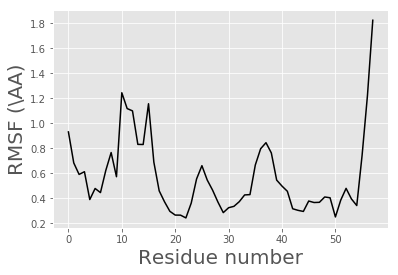

In [11]:
xx1 = np.std(caDevsMDall, 1);
rmsf_1 = np.mean(xx1.reshape((dim, Na)),0);
plt.plot(rmsf_1, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('RMSF (\AA)', fontsize=20);
plt.show();

In [12]:
mm = caDevsMDall.mean(1);
md = caDevsMDall.std(1);
cntArray = np.zeros((174,1));
for i in range(0, caDevsMDall.shape[0]):
    y = caDevsMDall[i,:]
    b = filter(lambda x: (x >= (mm[i] + 2.5*md[i]) or x <= (mm[i] - 2.5*md[i])), y); 
    cntArray[i] = len(list(b));

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


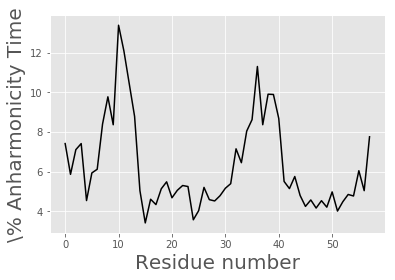

In [13]:
cntArray = cntArray.reshape((dim,Na));
bfactor = np.zeros((Na,1));
for i in range(0, Na):
    bfactor[i] = float(sum(cntArray[:,i]))*100/Nc;
plt.plot(bfactor, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('\% Anharmonicity Time', fontsize=20);
plt.show();


(174, 412497)
(58, 1)


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


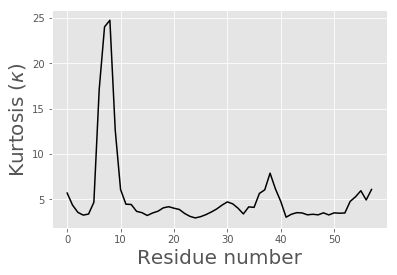

In [14]:
gK_Res = np.zeros((Na, 1)); 

print (caDevsMDall.shape); 
print (gK_Res.shape);
k = 0;
for i in range(0, gK_Res.shape[0]):
    kX = scipy.stats.kurtosis(caDevsMDall[i,:],0,fisher=False);
    kY = scipy.stats.kurtosis(caDevsMDall[i+1,:],0,fisher=False);
    kZ = scipy.stats.kurtosis(caDevsMDall[i+2,:],0,fisher=False);
    gK_Res[k] = np.mean([kX, kY, kZ],0);
    i = i + 3;
    k = k + 1;
kurt = scipy.stats.kurtosis(caDevsMDall,0,fisher=False);
plt.plot(gK_Res, 'k-');
plt.xlabel('Residue number', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.show();

## Kurtosis Test 

perResidue Kurtosis test is done for assessing statistical significance

Parameters:

          caDevsMDall: the C-alpha coordinates from MD simulation for BPTI trajectory
          windowsize: user specified window to choose the block size for KurtosisTest computation
          
Returns:

          n: number of windows for different window sizes
          
          gK_res: per residue kurtosis for different windows
          
          mean_kurtosis_window_vals: average kurtosis for per residue in the given window frame
          
          std_kurtosis_window_vals: standard deviations along the specified axis.
          
          Zscore: average computed Z-scores for the test
          
          pvalue: average 2-sided p-values for the hypothesis test
          
          
          
### Note: 
Average kurtosis, standard deviation, Z-score and 2-sided p-value is saved as a text file in the program directory

In [15]:
import scipy.stats
import numpy as np

def perResidueKurtosisTest(caDevsMDall, windowsize, resNum):
    n = caDevsMDall.shape[1]//windowsize; # gives the number of windows over entire trajectory 
    
    gK = np.zeros((caDevsMDall.shape[0], n));
    gKres = np.zeros((int(caDevsMDall.shape[0]/3), 1));
    gK_pval = np.zeros((caDevsMDall.shape[0], n));
    gK_Zscr = np.zeros((caDevsMDall.shape[0], n));
    gK_res = [];
    K_tmp = []; pval_tmp = []; zscr_tmp = [];
    for j in range(0, n):
        cc = caDevsMDall[:,(windowsize*j):(windowsize*(j+1)):];
        k = 0;
        # computing per residue kurtosis
        for i in range(0, gKres.shape[0]):
            kX = scipy.stats.kurtosis(cc[i,:],0,fisher=False);
            kY = scipy.stats.kurtosis(cc[i+1,:],0,fisher=False);
            kZ = scipy.stats.kurtosis(cc[i+2,:],0,fisher=False);
            gKres[k] = np.mean([kX, kY, kZ],0); 
            i = i + 3;
            k = k + 1;
        K_tmp = scipy.stats.kurtosis(cc, 1, fisher=False);
        zscr_tmp, pval_tmp = scipy.stats.kurtosistest(cc, 1); 
        gK[:,j] = K_tmp; 
        gK_res.append(gKres[resNum-1].tolist()); # get the kurtosis values over the windows for given residue number
        gK_pval[:,j] = pval_tmp;
        gK_Zscr[:,j] = zscr_tmp;
    mean_kurtosis_window_vals = np.mean(gK, axis=1); 
    std_kurtosis_window_vals = np.std(gK, axis=1); 
    pvalue = np.mean(gK_pval, axis=1);
    Zscore = np.mean(gK_Zscr, axis=1);
    return n, gK_res, mean_kurtosis_window_vals, std_kurtosis_window_vals,  pvalue, Zscore;

In [16]:
win_40, gK40_res8, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=40,resNum=8);

In [17]:
win_400, gK400_res8, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=400,resNum=8);
win_4000, gK4000_res8, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=4000,resNum=8);
win_40000, gK40000_res8, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=40000,resNum=8);
win_400000, gK400000_res8, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=400000,resNum=8);

In [18]:
win_40, gK40_res9, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=40,resNum=9);
win_400, gK400_res9, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=400,resNum=9);
win_4000, gK4000_res9, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=4000,resNum=9);
win_40000, gK40000_res9, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=40000,resNum=9);
win_400000, gK400000_res9, meank, stdev, pval, Zscore = perResidueKurtosisTest(caDevsMDall, windowsize=400000,resNum=9);

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


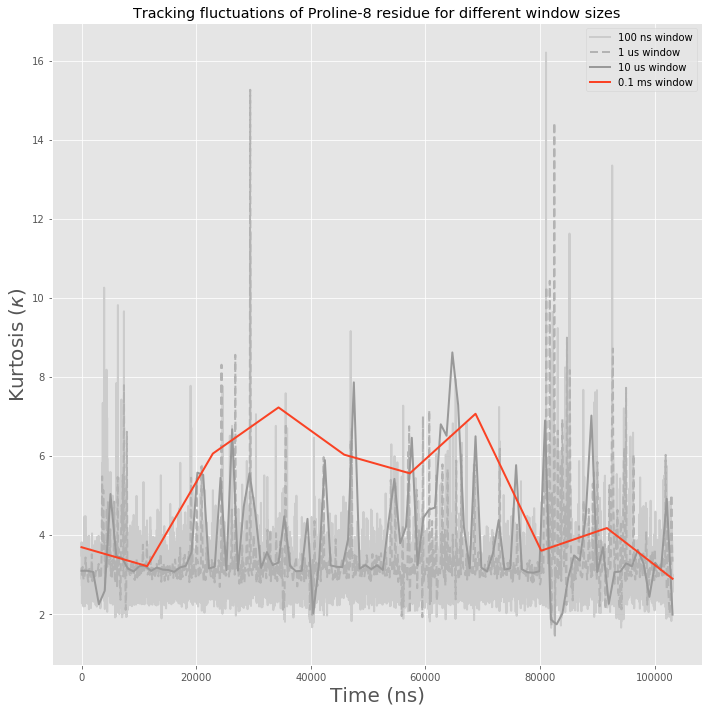

In [19]:
# Tracking fluctuations for Proline 8 residue by using measures of kurtosis
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot();   
ax.get_xaxis().tick_bottom();   
ax.get_yaxis().tick_left();

x = np.linspace(0,caDevsMDall.shape[1]/4, win_40);
ax.plot(x, gK40_res8, 'k-', linewidth=2.0, color = (0.8,0.8,0.8), label = '100 ns window'); 

x = np.linspace(0,caDevsMDall.shape[1]/4, win_400);
ax.plot(x, gK400_res8, 'k-', linewidth=2.0,linestyle='--', dashes=(4, 2), color = (0.7,0.7,0.7),label = '1 us window'); 

x = np.linspace(0,caDevsMDall.shape[1]/4, win_4000);
ax.plot(x, gK4000_res8, 'k-', linewidth=2.0, color = (0.6,0.6,0.6), label = '10 us window'); 

x = np.linspace(0,caDevsMDall.shape[1]/4, win_40000);
ax.plot(x, gK40000_res8, 'r-', linewidth=2.0, color = ('#fa4224'), label = '0.1 ms window'); 
ax.legend(loc='upper right')

plt.title('Tracking fluctuations of Proline-8 residue for different window sizes')
plt.xlabel('Time (ns)', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.tight_layout();
plt.show();

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


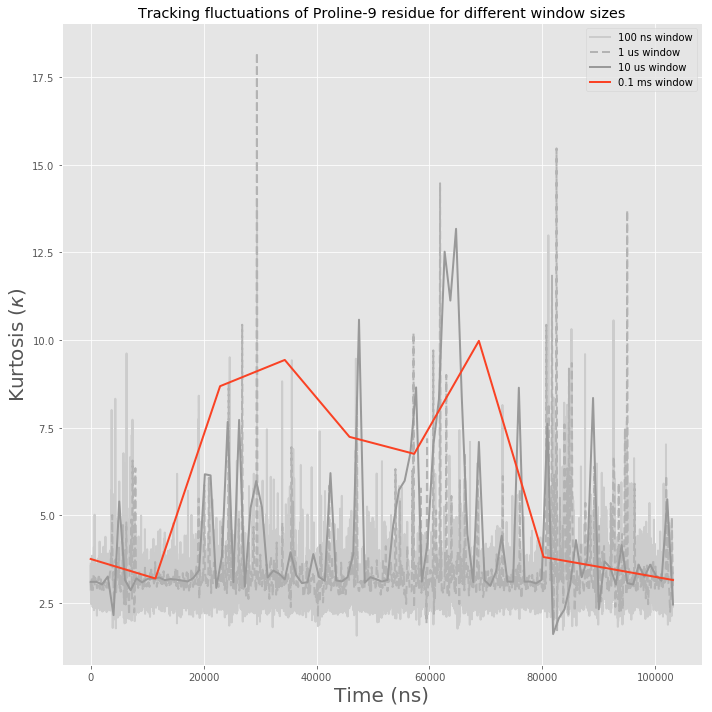

In [20]:
# Tracking fluctuations for Proline 9 residue by using measures of kurtosis
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot();   
ax.get_xaxis().tick_bottom();   
ax.get_yaxis().tick_left();

x = np.linspace(0,caDevsMDall.shape[1]/4, win_40);
ax.plot(x, gK40_res9, 'k-', linewidth=2.0, color = (0.8,0.8,0.8), label = '100 ns window'); 

x = np.linspace(0,caDevsMDall.shape[1]/4, win_400);
ax.plot(x, gK400_res9, 'k-', linewidth=2.0,linestyle='--', dashes=(4, 2), color = (0.7,0.7,0.7),label = '1 us window'); 

x = np.linspace(0,caDevsMDall.shape[1]/4, win_4000);
ax.plot(x, gK4000_res9, 'k-', linewidth=2.0, color = (0.6,0.6,0.6), label = '10 us window'); 

x = np.linspace(0,caDevsMDall.shape[1]/4, win_40000);
ax.plot(x, gK40000_res9, 'r-', linewidth=2.0, color = ('#fa4224'), label = '0.1 ms window'); 
ax.legend(loc='upper right')

plt.title('Tracking fluctuations of Proline-9 residue for different window sizes')
plt.xlabel('Time (ns)', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.tight_layout();
plt.show();

In [21]:
meanKurt = np.mean(meank.reshape(-1, 3), axis=1);
meanstdev = np.mean(stdev.reshape(-1, 3), axis=1);
meanpval = np.mean(pval.reshape(-1, 3), axis=1);
meanZscore = np.mean(Zscore.reshape(-1, 3), axis=1);

np.savetxt('Average Kurtosis', meanKurt, delimiter=' ');
np.savetxt('Standard deviations', meanstdev, delimiter=' ');
np.savetxt('p-value', meanpval, delimiter=' ');
np.savetxt('Z-score', meanZscore, delimiter=' ');